In [160]:
import numpy as np
import h5py
import torch
import torchmetrics
import torch.nn.functional as F
import pytorch_lightning as pl
from sklearn.preprocessing import OneHotEncoder 

from torch.utils.data import Dataset, DataLoader
from torch.nn import BatchNorm1d, Linear, ReLU, Sequential, MSELoss, Softmax, CrossEntropyLoss
from torch_geometric.nn import DynamicEdgeConv, global_mean_pool
from torch_geometric.data import Batch

import matplotlib.pyplot as plt

In [161]:
path='../project_data/small_set_1_train_0_shuffled.h5'
with h5py.File(path, "r") as f:
    enc_dict={-13:0,14:1,-14:2,12:3,-12:4}
    array=f["y"][7016:8032]['particle_type'].reshape(-1,1)

In [162]:
class HDF5Dataset(Dataset):
    def __init__(self, path, features=["pos_x", "pos_y", "pos_z", "time","tot", "dir_x", "dir_y", "dir_z"], y_feature="particle_type", particle_type=13.0, batch_size=16):
        """ Loads the data from the hdf5 format provided by OrcaSong and converts it to data that can be used by PyTorch
        
        Args:
            path (str): path to the dataset
            features (list[str]): List of features to select from the event data and use as input features
            y_feature  (str): Output feature to select
            particle_type (None or float):  ID of the particle you want to classify, it will be label 0 and all else will be label 1.
                                            Must be None when y_feature is not `particle_type`
            batch_size (int): number of samples in mini batch
        Examples:
            Electron vs Background classification (default):
            ```
                HDF5Dataset("pathtodata.h5", y_feature="particle_type", particle_type=13.0)
            ```
            Energy regression with only xyzct:
            ```
                HDF5Dataset("pathtodata.h5", features=["pos_x", "pos_y", "pos_z", "time"], y_feature="energy", particle_type=None)
            ```

        Lookup of table for particle_type of Leptons:
          electron          | 11
          electron neutrino | 12
          muon              | 13
          muon neutrino     | 14
          tau               | 15
          tau neutrino      | 16
        Antiparticle is the same as particle but with minus sign
        Source: https://pdg.lbl.gov/2007/reviews/montecarlorpp.pdf
        """
        with h5py.File(path, "r") as f:
            self.groups = list(dict(f).keys())
            self.length = len(f["y"]) // batch_size + 1
            self._max_index = len(f["y"])
            self.encoder=OneHotEncoder(sparse=False)
            self.encoder.fit(f["y"][:2000]['particle_type'].reshape(-1,1))
            print("The available y features are: ", f["y"][0].dtype.names)
        self.filename = path
        if y_feature!="particle_type":
            assert particle_type==None, "Selected a y_feature other than 'particle_type' and specified some value for particle_type as argument, which must be None for non particle_type output feature."
        self.y_feature = y_feature
        self.particle_type = particle_type
        self.batch_size = batch_size
        self._cache_x_column_names()
        self.x_mask = self.init_x_mask(features)


    def _cache_x_column_names(self):
        """Cache which columns are available in the features

        Raises:
            ValueError: It failed to read the hit_info columns
        """
        try:
            with h5py.File(self.filename, "r") as f:
                self.x_feature_dict = {
                    f["x"].attrs[f"hit_info_{i}"]: i for i in range(f["x"].shape[-1])
                }
            print("cached the following x input features", self.x_feature_dict)
        except Exception:
            raise ValueError("Can not read column names from dataset attributes")

    def init_x_mask(self, features):
        """Compute a mask that is used to select the feature columns from the data

        Args:
            features (list[str]): list of features present to load

        Returns:
            np.array: selection of column index from the features to use
        """
        x_mask = [self.x_feature_dict[feat] for feat in features]
        return np.array(x_mask)

    def __getitem__(self, index):
        """Get an sample from the h5 dataset
        x contains: (x,y,z,ct, dir_x, dir_y, dir_z)
        y contains a label 

        Args:
            index (int): index of the batch

        Returns:
            x (torch.Tensor): Tensor with the x data (for each of the vertices)
            y (torch.Tensor): Tensor with the y data (for the graph)
            batch_idx (torch.Tensor): Tensor that assigns the right batch index to each x point
        """
        with h5py.File(self.filename, "r") as f:
            index = slice(index * self.batch_size, min(self._max_index,(index + 1) * self.batch_size))
            
            x = f["x"][index]
            lengths = (np.sum(x[:, :, -1:], axis=1)).astype(int)
            batch_idx = np.hstack(
                  [
                      np.ones(length) * batch_idx
                      for batch_idx, length in enumerate(lengths)
                  ]
              )
            x = x[x[:, :, -1] == 1][:, self.x_mask]
            y = self.encoder.transform(f["y"][index][self.y_feature].reshape(-1,1)).argmax(1)
            y = torch.LongTensor(y)
            
        return x, y, torch.LongTensor(batch_idx)

    def __len__(self):
        return self.length

In [163]:
train_data = HDF5Dataset(path,features=["pos_x", "pos_y", "pos_z", "time","tot", "dir_x", "dir_y", "dir_z"], y_feature="particle_type", batch_size=16)

The available y features are:  ('event_id', 'particle_type', 'energy', 'is_cc', 'bjorkeny', 'dir_x', 'dir_y', 'dir_z', 'time_interaction', 'run_id', 'vertex_pos_x', 'vertex_pos_y', 'vertex_pos_z', 'n_hits', 'weight_w1', 'weight_w2', 'weight_w3', 'n_gen', 'prod_identifier', 'std_dir_x', 'std_dir_y', 'std_dir_z', 'std_beta0', 'std_lik', 'std_n_hits_gandalf', 'std_pos_x', 'std_pos_y', 'std_pos_z', 'std_energy', 'std_lik_energy', 'std_length', 'group_id')
cached the following x input features {'channel_id': 0, 'dir_x': 1, 'dir_y': 2, 'dir_z': 3, 'dom_id': 4, 'du': 5, 'floor': 6, 'group_id': 7, 'pos_x': 8, 'pos_y': 9, 'pos_z': 10, 't0': 11, 'time': 12, 'tot': 13, 'triggered': 14, 'is_valid': 15}


In [164]:
x,y,i=train_data.__getitem__(1)

In [209]:
class DECNetwork(pl.LightningModule):
    def __init__(self, batchnorm_kwargs=None, conf=None):
        """Dynamic EdgeConvolution Network https://arxiv.org/abs/1801.07829 with
           the dynamic KNN computation as presented in https://arxiv.org/abs/1902.08570 """
        super().__init__()
        ## Lightning configuration
        self.accuracy = pl.metrics.Accuracy()
        ## Defining the Network Architecture
        nn = Sequential(
            Linear(2 * 8, 64),
            BatchNorm1d(64),
            ReLU(),
            Linear(64, 64),
            BatchNorm1d(64),
            ReLU(),
            Linear(64, 64),
            BatchNorm1d(64),
            ReLU(),
        )
        self.edge_1 = DynamicEdgeConv(nn, aggr="mean", k=32)
        nn = Sequential(
            Linear(128, 128),
            BatchNorm1d(128),
            ReLU(),
            Linear(128, 128),
            BatchNorm1d(128),
            ReLU(),
            Linear(128, 128),
            BatchNorm1d(128),
            ReLU(),
        )
        self.edge_2 = DynamicEdgeConv(nn, aggr="mean", k=32)
        nn = Sequential(
            Linear(256, 256),
            BatchNorm1d(256),
            ReLU(),
            Linear(256, 256),
            BatchNorm1d(256),
            ReLU(),
            Linear(256, 256),
            BatchNorm1d(256),
            ReLU(),
        )
        self.edge_3 = DynamicEdgeConv(nn, aggr="mean", k=32)
        self.shortcut_1 = Sequential(Linear(8, 64), BatchNorm1d(64), ReLU())
        self.shortcut_2 = Sequential(Linear(64, 128), BatchNorm1d(128), ReLU())
        self.shortcut_3 = Sequential(Linear(128, 256), BatchNorm1d(256), ReLU())
        self.lin_1 = Linear(256, 256)
        self.lin_2 = Linear(256, 128)
        self.lin_3 = Linear(128, 5)
    
    def forward(self, data):
        x, batch_idx = data.x, data.batch
        # in lightning, forward defines the prediction/inference actions
        # edgeconv layer 1
        sc = self.shortcut_1(x)
        x = self.edge_1(x, batch_idx)
        x = F.relu(x + sc)
        # edgeconv layer 2
        sc = self.shortcut_2(x)
        x = self.edge_2(x, batch_idx)
        x = F.relu(x + sc)
        # edgeconv layer 3
        sc = self.shortcut_3(x)
        x = self.edge_3(x, batch_idx)
        x = F.relu(x + sc)
        x = global_mean_pool(x, batch=batch_idx)
        # now apply
        x = F.relu(self.lin_1(x))
        x = F.relu(self.lin_2(x))
        x = self.lin_3(x)
        return F.relu(x)
    
    def training_step(self, batch, batch_idx):
        # training_step defined the train loop. It is independent of forward
        batch = Batch(
            x=batch[0].squeeze(), y=batch[1].squeeze(), batch=batch[2].squeeze(),
        )
        out = self.forward(batch)
        loss = F.cross_entropy(out, batch.y)
        self.log("train_loss", loss)
        self.log('train_acc_step', self.accuracy(F.softmax(out,dim=-1), batch.y), on_epoch=False)
        return loss

    def validation_step(self, batch, batch_idx):
        batch = Batch(
            x=batch[0].squeeze(), y=batch[1].squeeze(), batch=batch[2].squeeze(),
        )
        y_hat = self.forward(batch)
        loss = F.cross_entropy(y_hat, batch.y)
        self.log("val_loss", loss)
        self.log('valid_acc', self.accuracy(F.softmax(y_hat, dim=-1), batch.y), on_step=True, on_epoch=True)
        #self.log('valid_matrix', self.confusionmatrix(F.softmax(y_hat), batch.y), on_epoch=True)
    
    def test_step(self,batch,batch_idx):
        batch = Batch(
            x=batch[0].squeeze(),y=batch[1].squeeze(),batch=batch[2].squeeze(),
        )
        y_hat = self.forward(batch)
        loss = F.cross_entropy(y_hat, batch.y)
        y_proba=F.softmax(y_hat, dim=-1)
        predictions_pred.append(y_proba)
        predictions_actual.append(batch.y)
        
        self.log("test_loss", loss)
        self.log('test_acc', self.accuracy(y_proba, batch.y), on_step=True, on_epoch=True)
        return {'test_loss': loss, 'y': batch.y, 'y_proba': y_proba}
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


In [210]:
train_data = HDF5Dataset(path,features=["pos_x", "pos_y", "pos_z", "time","tot", "dir_x", "dir_y", "dir_z"], y_feature="particle_type", batch_size=16)

train_loader = DataLoader(
    train_data,
    batch_size=1,
    num_workers=4,
    pin_memory=True,
    shuffle=False,
)


The available y features are:  ('event_id', 'particle_type', 'energy', 'is_cc', 'bjorkeny', 'dir_x', 'dir_y', 'dir_z', 'time_interaction', 'run_id', 'vertex_pos_x', 'vertex_pos_y', 'vertex_pos_z', 'n_hits', 'weight_w1', 'weight_w2', 'weight_w3', 'n_gen', 'prod_identifier', 'std_dir_x', 'std_dir_y', 'std_dir_z', 'std_beta0', 'std_lik', 'std_n_hits_gandalf', 'std_pos_x', 'std_pos_y', 'std_pos_z', 'std_energy', 'std_lik_energy', 'std_length', 'group_id')
cached the following x input features {'channel_id': 0, 'dir_x': 1, 'dir_y': 2, 'dir_z': 3, 'dom_id': 4, 'du': 5, 'floor': 6, 'group_id': 7, 'pos_x': 8, 'pos_y': 9, 'pos_z': 10, 't0': 11, 'time': 12, 'tot': 13, 'triggered': 14, 'is_valid': 15}


In [211]:
val_data = HDF5Dataset("../project_data/small_set_1_validate_0_shuffled.h5",features=["pos_x", "pos_y", "pos_z", "time","tot", "dir_x", "dir_y", "dir_z"], y_feature="particle_type", batch_size=32)
val_data.encoder=train_data.encoder
val_loader = DataLoader(
    val_data,
    batch_size=1,
    num_workers=4,
    pin_memory=True,
    shuffle=False,
)

The available y features are:  ('event_id', 'particle_type', 'energy', 'is_cc', 'bjorkeny', 'dir_x', 'dir_y', 'dir_z', 'time_interaction', 'run_id', 'vertex_pos_x', 'vertex_pos_y', 'vertex_pos_z', 'n_hits', 'weight_w1', 'weight_w2', 'weight_w3', 'n_gen', 'prod_identifier', 'std_dir_x', 'std_dir_y', 'std_dir_z', 'std_beta0', 'std_lik', 'std_n_hits_gandalf', 'std_pos_x', 'std_pos_y', 'std_pos_z', 'std_energy', 'std_lik_energy', 'std_length', 'group_id')
cached the following x input features {'channel_id': 0, 'dir_x': 1, 'dir_y': 2, 'dir_z': 3, 'dom_id': 4, 'du': 5, 'floor': 6, 'group_id': 7, 'pos_x': 8, 'pos_y': 9, 'pos_z': 10, 't0': 11, 'time': 12, 'tot': 13, 'triggered': 14, 'is_valid': 15}


In [212]:
#model = DECNetwork(batchnorm_kwargs={"eps": 1e-3, "momentum": 1e-1})
model = DECNetwork()

In [215]:
trainer = pl.Trainer(
    max_epochs=12,
    gpus=1,
    precision=32,
    log_every_n_steps=1000,
    progress_bar_refresh_rate=100,
    fast_dev_run=False,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [ ]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type            | Params
-----------------------------------------------
0 | accuracy   | Accuracy        | 0     
1 | edge_1     | DynamicEdgeConv | 9.8 K 
2 | edge_2     | DynamicEdgeConv | 50.3 K
3 | edge_3     | DynamicEdgeConv | 198 K 
4 | shortcut_1 | Sequential      | 704   
5 | shortcut_2 | Sequential      | 8.6 K 
6 | shortcut_3 | Sequential      | 33.5 K
7 | lin_1      | Linear          | 65.8 K
8 | lin_2      | Linear          | 32.9 K
9 | lin_3      | Linear          | 645   
-----------------------------------------------
401 K     Trainable params
0         Non-trainable params
401 K     Total params
1.605     Total estimated model params size (MB)


Epoch 0:  91%|█████████ | 25700/28179 [1:31:47<08:51,  4.67it/s, loss=0.903, v_num=32]
Validating: 0it [00:00, ?it/s]
Epoch 1:  91%|█████████ | 25700/28179 [1:31:56<08:52,  4.66it/s, loss=0.866, v_num=32]
Validating: 0it [00:00, ?it/s]
Epoch 2:  91%|█████████ | 25700/28179 [1:31:56<08:52,  4.66it/s, loss=0.859, v_num=32]
Validating: 0it [00:00, ?it/s]
Epoch 3:  24%|██▍       | 6700/28179 [23:50<1:16:25,  4.68it/s, loss=0.772, v_num=32] 

In [183]:
trainer.save_checkpoint(trainer.log_dir+"/trained_model.ckpt")

In [205]:
val_loader = DataLoader(
    val_data,
    batch_size=1,
    num_workers=4,
    pin_memory=True,
    shuffle=False,
)


In [189]:
predictions_pred = []
predictions_actual = []
trainer.test(model,val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 100%|██████████| 2493/2493 [02:48<00:00, 14.82it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.6521739363670349,
 'test_acc_epoch': 0.6544432640075684,
 'test_loss': 0.7578634023666382}
--------------------------------------------------------------------------------


[{'test_loss': 0.7578634023666382,
  'test_acc_epoch': 0.6544432640075684,
  'test_acc': 0.6521739363670349}]

In [190]:
probas=np.empty(5)
y_actual=np.empty(1)
for i in range(len(predictions_pred)):
    probas=np.vstack([probas,predictions_pred[i].cpu().numpy()])
    y_actual=np.vstack([y_actual,predictions_actual[i].cpu().numpy().reshape(-1,1)])

In [191]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm=confusion_matrix(y_actual.astype(int),probas.argmax(axis=1))

In [192]:
labels=list()
for name in val_data.encoder.get_feature_names():
    labels.append(name[3:])

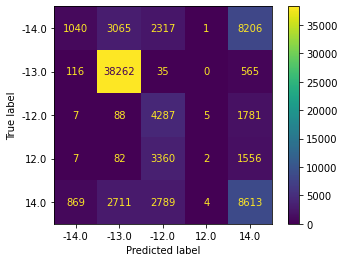

In [193]:
disp=ConfusionMatrixDisplay(cm,display_labels=labels)
disp.plot()

In [196]:
cm

array([[ 1040,  3065,  2317,     1,  8206],
       [  116, 38262,    35,     0,   565],
       [    7,    88,  4287,     5,  1781],
       [    7,    82,  3360,     2,  1556],
       [  869,  2711,  2789,     4,  8613]])

In [ ]:
disp.figure_.savefig('confusion_matrix_run31')

In [ ]:
inference = DECNetwork().load_from_checkpoint(checkpoint_path="lightning_logs/version_31/trained_model.ckpt")